In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import numpy as np
import tensorflow as tf

/Users/JundongQiao/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pandas as pd 

import sklearn
import h5py
import os
import getpass
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, r2_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [23]:
%matplotlib inline

In [4]:
import logging
logging.getLogger('tensorflow').disabled = True

In [5]:
# Import Data
DATA_DIR ='/Users/{}/Dropbox/VirtualBeach/Regression'.format(getpass.getuser())
train_eval_test = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_2008_2018_16_features_target.csv'), header='infer', sep=',', index_col=0)
train_eval_test.reindex(range(len(train_eval_test)))

ecoli_threshold = 235.
X = train_eval_test.iloc[:,2:].copy()
y = train_eval_test.iloc[:,1].copy().apply(lambda x: 1 if x>np.log10(ecoli_threshold) else 0)


In [6]:
X.head()

,Lake_Turb_NTU,Local_Rain24_in,BarPressureInst_inhg,Stream_Turb_NTU,WaveHt_Ft,Perp_WaveDir_24hr,AirportRain24_in,WindDirInst_deg,Perp_WaveHt_24hr,CloudCover_24hr,AirportRain48_in,WindSpInst_mph,NvWater_24hr,AirportRain48W_in,WaterTemp_24hr,WindSpAnt24_mph
0,6.0,0.29,29.13,22.9,10.0,-0.926470,0.365,210,-0.456460,0.393545,0.005,9,0.104740,0.735,18.92864,13.180346
1,37.4,0.30,29.33,94.0,12.0,-0.939580,0.145,230,-0.767450,0.373123,0.365,13,0.112342,0.655,19.01393,12.759849
2,17.0,0.00,29.55,26.7,2.0,-0.257170,0.000,90,-0.189570,0.266800,0.145,10,0.071394,0.145,19.44413,3.717010
3,3.6,0.00,29.35,32.8,12.0,0.711815,0.005,190,0.155129,0.127086,0.000,11,0.018950,0.010,19.74451,7.467855
4,11.4,0.42,29.21,246.0,12.0,-0.727880,0.375,230,-0.159540,0.537216,0.005,14,0.057213,0.755,20.52881,8.645382


In [15]:
# Feature columns for input into the model
FEATURE_COLUMNS = list(X.columns.values)

In [17]:
X.describe()

,Lake_Turb_NTU,Local_Rain24_in,BarPressureInst_inhg,Stream_Turb_NTU,WaveHt_Ft,Perp_WaveDir_24hr,AirportRain24_in,WindDirInst_deg,Perp_WaveHt_24hr,CloudCover_24hr,AirportRain48_in,WindSpInst_mph,NvWater_24hr,AirportRain48W_in,WaterTemp_24hr,WindSpAnt24_mph
count,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.00000,641.000000,641.000000,641.000000,641.000000
mean,31.558822,0.126484,29.626178,48.303073,7.210499,-0.505160,0.113510,174.274571,-0.339944,0.524794,0.165023,6.73791,0.033273,0.373370,21.401601,6.478742
std,46.712085,0.298896,0.410317,103.918173,6.358478,0.548022,0.285661,89.726909,0.363270,0.211712,0.365634,3.87580,0.050074,0.739305,3.162188,3.102172
min,0.940000,0.000000,28.710000,6.810000,0.000000,-0.984579,0.000000,0.000000,-1.811840,0.004466,0.000000,0.00000,-0.145121,0.000000,10.884109,0.361967
25%,5.780000,0.000000,29.240000,18.100000,2.000000,-0.921150,0.000000,120.000000,-0.546814,0.371085,0.000000,4.00000,-0.003404,0.000000,19.348120,4.123120
50%,15.950000,0.000000,29.730000,25.400000,6.000000,-0.758700,0.000000,200.000000,-0.278813,0.527943,0.010000,6.00000,0.040692,0.060000,22.163838,6.542602
75%,39.750000,0.095000,30.000000,37.850000,11.000000,-0.244516,0.070000,230.000000,-0.071636,0.692704,0.140000,9.00000,0.073434,0.400000,23.628920,8.563260
max,601.000000,2.700000,30.390000,1000.000000,35.000000,0.975504,2.490000,360.000000,0.423006,1.000000,2.730000,22.00000,0.137144,7.310000,26.134250,17.290886


In [19]:
X.corr()

,Lake_Turb_NTU,Local_Rain24_in,BarPressureInst_inhg,Stream_Turb_NTU,WaveHt_Ft,Perp_WaveDir_24hr,AirportRain24_in,WindDirInst_deg,Perp_WaveHt_24hr,CloudCover_24hr,AirportRain48_in,WindSpInst_mph,NvWater_24hr,AirportRain48W_in,WaterTemp_24hr,WindSpAnt24_mph
Lake_Turb_NTU,1.000000,0.124680,-0.098980,0.043593,0.433601,-0.369461,0.117111,0.250071,-0.617671,0.085314,0.138056,0.157014,0.261480,0.156613,0.047318,0.477039
Local_Rain24_in,0.124680,1.000000,-0.124947,0.401577,0.135920,0.016218,0.750592,0.019329,-0.008500,0.416763,0.327989,0.126852,0.121405,0.680167,-0.001080,0.074541
BarPressureInst_inhg,-0.098980,-0.124947,1.000000,-0.132220,-0.262275,0.085020,-0.134656,-0.148202,0.084727,-0.172933,0.037481,-0.325578,-0.136356,-0.106386,-0.133899,-0.147434
Stream_Turb_NTU,0.043593,0.401577,-0.132220,1.000000,0.074551,-0.009026,0.345604,0.100525,-0.027926,0.187213,0.137177,0.133140,0.081146,0.297955,0.020674,0.052351
WaveHt_Ft,0.433601,0.135920,-0.262275,0.074551,1.000000,-0.484868,0.127651,0.473779,-0.564626,0.191328,0.103858,0.452003,0.432704,0.158791,0.136985,0.540344
Perp_WaveDir_24hr,-0.369461,0.016218,0.085020,-0.009026,-0.484868,1.000000,0.020416,-0.355725,0.763551,-0.016324,-0.027963,-0.127802,-0.610323,-0.011624,-0.175912,-0.398950
AirportRain24_in,0.117111,0.750592,-0.134656,0.345604,0.127651,0.020416,1.000000,0.026701,-0.003396,0.378877,0.442496,0.095711,0.116524,0.900726,0.006754,0.072584
WindDirInst_deg,0.250071,0.019329,-0.148202,0.100525,0.473779,-0.355725,0.026701,1.000000,-0.340682,0.056311,0.099299,0.458097,0.305775,0.079699,0.026345,0.366507
Perp_WaveHt_24hr,-0.617671,-0.008500,0.084727,-0.027926,-0.564626,0.763551,-0.003396,-0.340682,1.000000,-0.074052,-0.094674,-0.123708,-0.515495,-0.063109,-0.196941,-0.589563
CloudCover_24hr,0.085314,0.416763,-0.172933,0.187213,0.191328,-0.016324,0.378877,0.056311,-0.074052,1.000000,0.291315,0.140306,0.108462,0.404514,-0.121822,0.107691


## Input file parsing

In [20]:
BATCH_SIZE = 40
# https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn
def generate_input_fn(filename, num_epochs=None, shuffle=True, batch_size=BATCH_SIZE):
  
    return tf.estimator.inputs.pandas_input_fn(
        x=X,
        y=y,
        batch_size=batch_size,
        num_epochs=num_epochs,
        shuffle=shuffle)

print('input function configured')

input function configured


In [22]:
type(tf.feature_column.numeric_column('Lake_Turb_NTU'))

tensorflow.python.feature_column.feature_column._NumericColumn

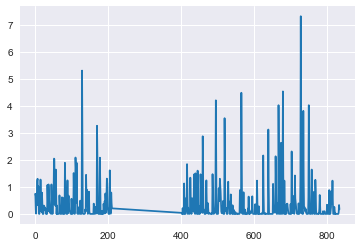

In [24]:
X['AirportRain48W_in'].plot()

In [ ]:
# Transformations.
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[ 18, 25, 30, 35, 40, 45, 50, 55, 60, 65 ])

education_occupation = tf.feature_column.crossed_column(
    ["education", "occupation"], hash_bucket_size=int(1e4))

age_race_occupation = tf.feature_column.crossed_column(
    [age_buckets, "race", "occupation"], hash_bucket_size=int(1e6))

country_occupation = tf.feature_column.crossed_column(
    ["native_country", "occupation"], hash_bucket_size=int(1e4))

print('Transformations complete')

In [1]:
# Import Data
DATA_DIR ='/Users/{}/Dropbox/VirtualBeach/Regression'.format(getpass.getuser())
train_eval_test = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_2008_2018_16_features_target.csv'), header='infer', sep=',', index_col=0)
train_eval_test.reindex(range(len(train_eval_test)))

ecoli_threshold = 235.
X = train_eval_test.iloc[:,2:].copy()
y = train_eval_test.iloc[:,1].copy().apply(lambda x: 1 if x>np.log10(ecoli_threshold) else 0)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=456)
# X_train , X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.15, stratify=y_train_val, random_state=456)

# Oversampling using SMOTE
sm = SMOTE(random_state=456)
X_res, y_res = sm.fit_sample(X_train_val, y_train_val) # return X_res, y_res as np.array
X_res_df = pd.DataFrame(data=X_res, columns = X_train_val.columns)

print X_train_val.shape
print X_res.shape

/Users/JundongQiao/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(512, 16)
(708, 16)


/Users/JundongQiao/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
dtrain = xgb.DMatrix(X_res_df, label=y_res)
# dval   = xgb.DMatrix(x_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)


param = {'max_depth':3, 'eta':0.002, 'silent':1, 'objective':'binary:logistic', 'eval_metric':'logloss'}
num_round = 1500
# watchlist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round)#, watchlist)#, early_stopping_rounds=10)

# Make prediction

preds = bst.predict(dtest)
y_pred = map(lambda x: 1 if x>0.50 else 0, preds)
print preds
print accuracy_score(y_test, y_pred)
print classification_report(y_test, y_pred)

# Print confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
print c_matrix



[0.22446829 0.11298828 0.2330149  0.23768169 0.26539284 0.9039073
 0.5514137  0.12617788 0.5929341  0.30445644 0.2126207  0.8439858
 0.5203546  0.5456988  0.23302963 0.7091967  0.33996353 0.2965645
 0.2226548  0.3713963  0.72257537 0.57074475 0.89525795 0.14940472
 0.39907554 0.2983341  0.54107344 0.14838326 0.25447506 0.4519579
 0.5930149  0.18201047 0.19067056 0.09586955 0.11224493 0.5114446
 0.22338459 0.1763484  0.74698836 0.21112879 0.7664229  0.25509632
 0.9029681  0.47406626 0.39235947 0.14872941 0.19560792 0.67155236
 0.5620098  0.41537008 0.3799119  0.30920622 0.89109045 0.6968366
 0.24620523 0.86351174 0.29071862 0.7750872  0.4202682  0.16737455
 0.1526365  0.27358937 0.3937726  0.20111184 0.42479298 0.2158023
 0.10754559 0.2571366  0.70157325 0.3310677  0.7226236  0.31339532
 0.12312878 0.8443701  0.15789905 0.45226064 0.5128941  0.5519123
 0.54336387 0.2463384  0.38526896 0.36334708 0.17503813 0.28089225
 0.22786452 0.53961384 0.25284708 0.34714004 0.2734697  0.13700731
 0.

In [33]:
%matplotlib inline

In [29]:
y_test.values

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

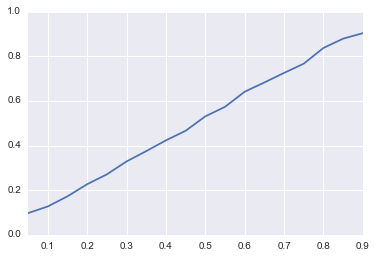

In [72]:
# pred_group = y_test.values//0.05 * 0.05
# y_test_series = pd.Series(y_test)
# y_test_series.groupby(pred_group).mean().plot()

# pred_group_ = preds//0.05 * 0.05
# y_pred_series = pd.Series(preds)
# y_pred_series.groupby(pred_group_).mean().plot()

In [ ]:
# Convert Input (np.array) into DMatrix
# dtrain = xgb.DMatrix(X_res_df, label=y_res)
# dval   = xgb.DMatrix(X_val, label=y_val)
# dtest  = xgb.DMatrix(X_test, label=y_test)

# Using GridSearchCV to find best parameters
params = {
                'learning_rate': [0.001, 0.005, 0.01,  0.05, 0.1],
                'n_estimators': [1000, 1500, 2000],
                'max_depth': [3, 4, 5],
                'gamma': [i/10.0 for i in range(0,4)],
                'subsample': [i/10.0 for i in range(7,10)],
                'colsample_bytree': [i/10.0 for i in range(7,10)],
                'reg_alpha':[1e-5, 1e-2, 0.1, 1]        
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5, \
                                         min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, \
                                        objective= 'binary:logistic', n_jobs=4, scale_pos_weight=1, random_state=456), \
                                        param_grid = params, scoring='roc_auc', n_jobs=4, iid=False, cv=5)

gsearch.fit(X_res, y_res)

means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print "~~~~~~~~~~~~~~"
print gsearch.best_params_
print "~~~~~~~~~~~~~~"
print gsearch.best_score_

# Pick the best estimator through cross validation
bst = gsearch.best_estimator_

# Make prediction
y_pred = bst.predict(X_test.values)

print accuracy_score(y_test, y_pred)
print classification_report(y_test, y_pred)

# Print confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
print c_matrix

'''
# eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_metric = ["auc","error"]
param = {'max_depth':4, 'eta':0.005, 'silent':1, 'objective':'binary:logistic', 'eval_metric':'logloss', \
'subsample': '0.8', 'colsample_bytree': '0.5'}
num_round = 2000
watchlist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, watchlist)#, early_stopping_rounds=10)

# Make prediction
preds = bst.predict(dtest)
y_pred = map(lambda x: 1 if x>0.50 else 0, preds)
# print preds
print accuracy_score(y_test, y_pred)
print classification_report(y_test, y_pred)

# Print confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
print c_matrix

# sns.heatmap(c_matrix, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=y_test, yticklabels=y_test)
# plt.xlabel('Predicted label')
# plt.ylabel('True label');
# plt.show()
'''

